In [1]:
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
import astropy.units as un

In [2]:
F_STAR10 = -2.7619389378877255 # from Ivan
F_STAR7_MINI = -4.2 # adjusted to ensure continuity with ACGs at M_h = 10**8 M_sun
F_ESC10 = -1.35
F_ESC7_MINI = -1.35
ALPHA_STAR = 0.897330537277276630 # from Ivan
ALPHA_STAR_MINI = -0.3 # adjusted to ensure continuity with ACGs at M_h = 10**8 M_sun
ALPHA_ESC = -0.3
M_TURN = 5.0
t_STAR = 0.173760590479019067 #from Ivan
L_X = 40.5
NU_X_THRESH = 500
SIGMA_STAR = 0.14 # from Ivan
SIGMA_LX = 0.5
SIGMA_SFR_LIM = 0.19 # ~ from Ivan
SIGMA_SFR_INDEX = -0.12
R_BUBBLE_MAX = 50.0

In [16]:
def get_M_ast(f_ast, alpha_ast, M_h, M=10):
    if not hasattr(f_ast, "__len__"):
        f_ast = np.array([f_ast])
    if not hasattr(alpha_ast, "__len__"):
        alpha_ast = np.array([alpha_ast])
    M = 10**(M)#M_sun
    m_ast = np.zeros((alpha_ast.shape[0], M_h.shape[0]))
    for i in range(M_h.shape[0]):
        m_ast[:,i] = 10**f_ast * (10**M_h[i] / M)**alpha_ast * Planck15.Ob0/Planck15.Om0 * 10**M_h[i]
    return  np.log10(m_ast).squeeze()

def get_SFMS(M_ast, t_ast, z):
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    if not hasattr(z, "__len__"):
        z = np.array([z])
    sfms = np.zeros(( z.shape[0],M_ast.shape[0]))
    for i in range(z.shape[0]):
        H = Planck15.H(z[i]).to(1/un.year).value
        sfms[i,:] = np.log10((10**M_ast) / (t_ast / H))
    return sfms

def get_Santini17_SFMS(M_ast, z, M=9.7):
    if z >= 4 and z <= 5:
        slope = 0.94 
        intercept = 1.37
    elif z >= 5 and z <= 6:
        slope = 0.92
        intercept = 1.99
    else:
        raise ValueError("Santini+17 goes up to z = 6")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M = 10**M
    M_ast[M_ast < 10**8] = np.nan
    return slope*np.log10(M_ast/M) + intercept

def get_Rinaldi22_SFMS(M_ast, z):
    if z >= 4 and z <= 5:
        slope = 0.6 
        intercept = -4.93
    elif z >= 5 and z <= 6.5:
        slope = 0.59
        intercept = -4.79
    else:
        raise ValueError("Rinaldi+22 goes up to z = 6.5")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M_ast[M_ast < 10**6] = np.nan
    return slope*np.log10(M_ast) + intercept

# SHMR

In [46]:
from matplotlib import rcParams
rcParams.update({"font.size":20, "font.family": 'serif'})

In [47]:
M_h_ACG = np.log10(np.logspace(8,10,1000))
SHMR_ACG = get_M_ast(F_STAR10, ALPHA_STAR, M_h_ACG)

M_h_MCG = np.log10(np.logspace(5,8,1000))
SHMR_MCG = get_M_ast(F_STAR7_MINI, ALPHA_STAR_MINI, M_h_MCG, M=7)

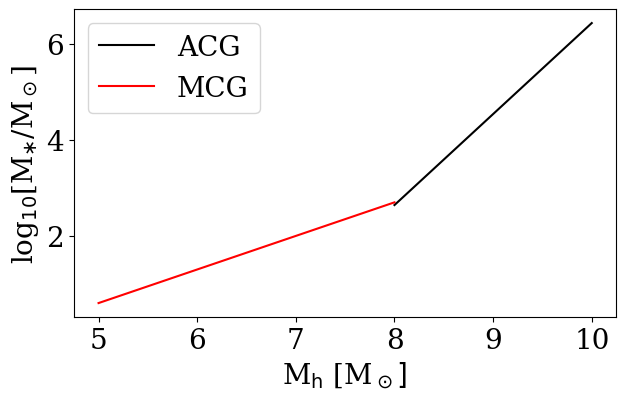

In [50]:
fig, ax = plt.subplots(1,1,figsize = (7,4))
ax.plot(M_h_ACG, SHMR_ACG, label = "ACG", color = "k")
ax.plot(M_h_MCG, SHMR_MCG, label = "MCG", color = "r")
ax.set_xlabel(r'M$_{\rm h}$ [M$_\odot]$')
ax.set_ylabel(r'log$_{10}$[M$_{\ast}$/M$_\odot$]')
plt.legend()
plt.show()

# SFMS

In [26]:
import matplotlib

In [27]:
redshifts = np.logspace(np.log10(5), np.log10(35), 10)
M_STAR = np.log10(np.logspace(5, 12, 100))

SFMS = get_SFMS(M_STAR, t_STAR, redshifts)

In [28]:
n_lines = SFMS.shape[0]
cmap = matplotlib.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

In [29]:
Santini_z5 = get_Santini17_SFMS(10**M_STAR, 5)
Santini_z6 = get_Santini17_SFMS(10**M_STAR, 6)

Rinaldi_z5 = get_Rinaldi22_SFMS(10**M_STAR, 5)
Rinaldi_z6 = get_Rinaldi22_SFMS(10**M_STAR, 6)

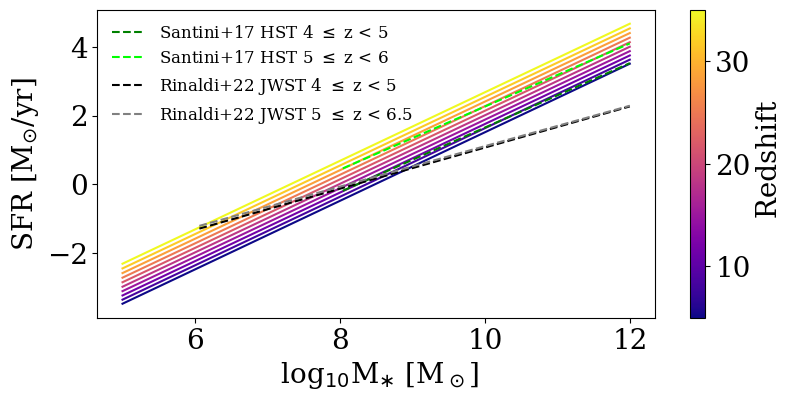

In [45]:
fig, ax = plt.subplots(1,1,figsize = (9,4))
cmap = matplotlib.colormaps["plasma"]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=redshifts[0], vmax=redshifts[-1]))
for i in range(SFMS.shape[0]):
    ax.plot(M_STAR, SFMS[i,:], color = colors[i])
plt.plot(M_STAR, Santini_z5, label = r"Santini+17 HST 4 $\leq$ z < 5", ls = "--", color = "g")
plt.plot(M_STAR, Santini_z6, label = r"Santini+17 HST 5 $\leq$ z < 6", ls = "--", color = "lime")

plt.plot(M_STAR, Rinaldi_z5, label = r"Rinaldi+22 JWST 4 $\leq$ z < 5", ls = "--", color = "k")
plt.plot(M_STAR, Rinaldi_z6, label = r"Rinaldi+22 JWST 5 $\leq$ z < 6.5", ls = "--", color = "grey")
ax.set_xlabel(r" log$_{10}$M$_{\ast}$ [M$_\odot$]")
ax.set_ylabel(r'SFR [M$_{\odot}$/yr]')
plt.colorbar(sm, ax=ax, label = r" Redshift")
plt.legend(fontsize = 12, frameon=False)
plt.show()